In [263]:
%matplotlib widget
import pylab as plt
import numpy as np
from astropy.io import fits
from glob import glob
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import HuberRegressor
from joblib import dump,load

import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

In [41]:
# I need to set a test set first

n = 15
#test splitter
df_index = np.arange(n)
fake_labels = np.arange(n)+100

data = np.arange(n*3).reshape([n,3])
df = pd.DataFrame(data)
df['index'] = df_index

# Definitions

In [252]:
def poly_continuum(y,x):
    #note the change in argument order in this version
    # this fits a poly to the continuum

    # assumes wavelength array is in nm
    # and that fluctuations are in 10nm scale
    order = int((x[-1]-x[0])/(10))

    try:
        # standardize    
        x_scaler, y_scaler = StandardScaler(), StandardScaler()
        x_train = x_scaler.fit_transform(x[..., None])
        y_train = y_scaler.fit_transform(y[..., None])

        # fit model
        model = Pipeline([('poly', PolynomialFeatures(degree=order)),
                  ('linear', HuberRegressor())])

        model.fit(x_train, y_train.ravel())

        # do some predictions
        # predictions = y_scaler.inverse_transform(
        #     model.predict(x_scaler.transform(x[..., None]))
        #     )
        test_x_transformed = x_scaler.transform(x[..., None])
        y_transformed = model.predict(test_x_transformed)
        predictions = y_scaler.inverse_transform(y_transformed[..., None])
        return(predictions.ravel())
    except ValueError as e:
        print(e)
        print('couldn\'t fit continuum this time! probably too flat already...')
        return(np.ones_like(y))

def Huber_continuum(y,x):
    #note the change in arguments order in this version
    try:
        # standardize    
        x_scaler, y_scaler = StandardScaler(), StandardScaler()
        x_train = x_scaler.fit_transform(x[..., None])
        y_train = y_scaler.fit_transform(y[..., None])

        # fit model
        model = HuberRegressor(epsilon=1)
        model.fit(x_train, y_train.ravel())

        # do some predictions
        test_x = x
        
        test_x_transformed = x_scaler.transform(test_x[..., None])
        y_transformed = model.predict(test_x_transformed)
        predictions = y_scaler.inverse_transform(y_transformed[..., None])

        return(predictions.ravel())
    except ValueError as e:
        print(e)
        print('couldn\'t fit continuum this time! probably too flat already...')
        return(np.ones_like(y))

class NormalizeSpectra(BaseEstimator, TransformerMixin):

    def __init__(self,continuum_type=Huber_continuum):
        self.continuum_type=continuum_type

    def fit(self,X,y=None):
        X = check_array(X)  # checks that X is an array with finite float values

        # note that first row of X contains wavelengths, the rest have fluxes
        continua = np.apply_along_axis(self.continuum_type,1,X[1:,:],X[0,:])
        
        # here we need to return an array with wl in the first row
        self.continuum_fitted_ = np.append(X[0,:][None,...],continua,axis=0)
        
        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!
    
    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]

        # Since 1st row is wl we skip it
        normalized_fluxes =  X[1:,:] / self.continuum_fitted_[1:,:]
        
        # we return an array with wl in 1st row, as it was fed.
        return np.append(X[0,:][None,...],normalized_fluxes,axis=0) 

# Load data

In [ ]:
# idir = '/Users/cabrera-ziri/Work/data/eso/reticulum/Results/sky_res/'
idir = '/Users/cabrera-ziri/Work/data/eso/reticulum/OneDrive_1_17-01-2024/sky_res/'

# read all sky spectra
files = glob(idir+'sky*.fits')

# to do: try to implement a proper sklearn pipeline for this
# (i.e. replace nans, create errors if not provided, etc)

for i,file in enumerate(files):	
	hdu = fits.open(file)

	# I would have tried to use the pipeline error spectra but the are very 
	# funky (values close to 0 and also many negatives). For the rest of 
	# the tests I'm using the sqrt of the flux as the uncertainty
	# hdu_e = fits.open(file.replace('sky.','err.'))

	# wavelenght0
	ext=0 
	crval = hdu[ext].header['crval1']
	cdelt = hdu[ext].header['cdelt1']
	naxis = hdu[ext].header['naxis1']
	
	wl = crval+cdelt*np.arange(naxis)
	flux = hdu[ext].data +100 #I'm offsetting the flux by 100 to try something out (avoid dealing with negavites)

	# err = hdu_e[ext].data
	err = np.sqrt(np.abs(flux))

	#normalise flux spectrum
	flux_continuum = Huber_continuum(wl,flux)
	flux = flux/flux_continuum
	
	#normalise error spectrum
	err_continuum = Huber_continuum(wl,err)

	if np.sum(err==0):
		#if there are 0s in error array replace with continuum
		#this avoids NaNs later down the road
		err[err==0] = err_continuum[err==0]

	if i == 0:
		#create array in first iteration 
		flux_array = np.empty(shape=(len(files),len(wl)))

	# fill array with flux of sky spectra normalised by its errors
	flux_array[i,:] = flux/(err/err_continuum)
	# break


HuberRegressor convergence failed: l-BFGS-b solver terminated with ABNORMAL_TERMINATION_IN_LNSRCH
couldn't fit continuum this time! probably too flat already...


In [240]:
# idir = '/Users/cabrera-ziri/Work/data/eso/reticulum/Results/sky_res/'
idir = '/Users/cabrera-ziri/Work/data/eso/reticulum/OneDrive_1_17-01-2024/sky_res/'

# read all sky spectra
files = glob(idir+'sky*.fits')

# to do: try to implement a proper sklearn pipeline for this
# (i.e. replace nans, create errors if not provided, etc)

for i,file in enumerate(files):	
	hdu = fits.open(file)

	# I would have tried to use the pipeline error spectra but the are very 
	# funky (values close to 0 and also many negatives). For the rest of 
	# the tests I'm using the sqrt of the flux as the uncertainty
	# hdu_e = fits.open(file.replace('sky.','err.'))

	# wavelenght0
	ext=0 
	crval = hdu[ext].header['crval1']
	cdelt = hdu[ext].header['cdelt1']
	naxis = hdu[ext].header['naxis1']
	
	wl = crval+cdelt*np.arange(naxis)
	flux = hdu[ext].data #+100 #I'm offsetting the flux by 100 to try something out (avoid dealing with negavites)

	if i == 0:
		#create array in first iteration 
		flux_array = np.empty(shape=(len(files),len(wl)))
	flux_array[i,:] = flux

	# # err = hdu_e[ext].data
	# err = np.sqrt(np.abs(flux))

	# #normalise flux spectrum
	# flux_continuum = Huber_continuum(wl,flux)
	# flux = flux/flux_continuum
	
	# #normalise error spectrum
	# err_continuum = Huber_continuum(wl,err)

	# if np.sum(err==0):
	# 	#if there are 0s in error array replace with continuum
	# 	#this avoids NaNs later down the road
	# 	err[err==0] = err_continuum[err==0]

	# if i == 0:
	# 	#create array in first iteration 
	# 	flux_array = np.empty(shape=(len(files),len(wl)))

	# # fill array with flux of sky spectra normalised by its errors
	# flux_array[i,:] = flux/(err/err_continuum)
	# # break


In [241]:
# here we split data in a training set and a test set
train_set,test_set = train_test_split(flux_array,test_size=0.2,random_state=42)
                                                  
# if we were to have a propper error specs from pipeline
# we should do the same to them here

print('spec. in training set: {:}'.format(len(train_set)))
print('spec. in test set: {:}'.format(len(test_set)))

# we put fluxes adn wl in a single array where the
# first row contains wavelengths
X_train = np.append(wl[None,...],train_set,axis=0)
X_test = np.append(wl[None,...],test_set,axis=0)

print('X_train shape:',X_train.shape,'Note that the first row of X contains wavelengths')

spec. in training set: 261
spec. in test set: 66
X_train shape: (262, 10220) Note that the first row of X contains wavelengths


In [223]:
# now we create a pipeline to take raw fluxes and 
# process them to be ready for PCA analysis

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self,func=np.sum):
        self.func = func
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return np.apply_along_axis(self.func,1,X)
    
# class NormalizeSpectra(BaseEstimator, TransformerMixin):
#     def __init__(self,continuum_type=Huber_continuum):
#         self.continuum_type=continuum_type

#     def fit(self,X,y=None):
#         X = check_array(X)  # checks that X is an array with finite float values

#         # remember that first row of X contains wavelengths, the rest have fluxes.
#         continua = np.apply_along_axis(self.continuum_type,1,X[1:,:],X[0,:])
        
#         self.continuum_fitted_ = np.append(X[0,:][None,...],continua,axis=0)
        
#         self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
#         return self  # always return self!
    
#     def transform(self, X):
#         check_is_fitted(self)  # looks for learned attributes (with trailing _)
#         X = check_array(X)
#         assert self.n_features_in_ == X.shape[1]

#         # normalize fluxes
#         normalized_fluxes =  X[1:,:] / self.continuum_fitted_[1:,:]
        
#         return np.append(X[0,:][None,...],normalized_fluxes,axis=0) 
    


In [275]:
X =  X_train.copy()

normalizer = NormalizeSpectra(poly_continuum)
normalizer.fit(X)
normalized = normalizer.transform(X)

#poly
rmse_poly = mean_squared_error(X[1:,:],normalizer.continuum_fitted_[1:,:],squared=False)

X =  X_train.copy()

normalizer = NormalizeSpectra()
normalizer.fit(X)
normalized = normalizer.transform(X)

# huber
rmse_huber = mean_squared_error(X[1:,:],normalizer.continuum_fitted_[1:,:],squared=False)

#huber runs x3 faster and produces same result.
print('rmse_poly: {:}\nrmse_huber: {:}'.format(rmse_poly.round(2),rmse_huber.round(2)))

rmse_poly: 564.1339609878361
rmse_huber: 564.1718488943241


rmse_poly: 564.13
rmse_huber: 564.17


In [274]:
X =  X_train.copy()

normalizer = NormalizeSpectra()
normalizer.fit(X)
normalized = normalizer.transform(X)

#huber
mean_squared_error(X[1:,:],normalizer.continuum_fitted_[1:,:],squared=False)

564.1718488943241

(-20.0, 20.0)

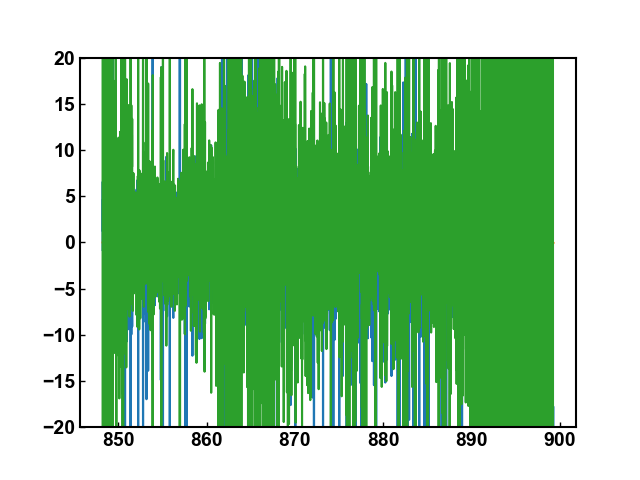

In [262]:
# _ = NormalizeSpectra()
# cont = _.fit(X)
n = 4
plt.close('all')
plt.figure()
plt.plot(X[0,:],X[n,:])
plt.plot(normalizer.continuum_fitted_[0,:],normalizer.continuum_fitted_[n,:])
plt.plot(normalized[0,:],normalized[n,:])
# plt.semilogy()
plt.ylim(-20,20)

In [155]:
cont.continuum_fitted_.ravel()

array([873.71947716, 873.77204677, 873.80594137, ..., 874.18089871,
       874.12437841, 874.06453115])

In [116]:
print(data)
_ = StandardScalerClone(func=myfunc)
data.mean(axis=1),_.transform(data,0.1)

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]
 [21 22 23]
 [24 25 26]
 [27 28 29]
 [30 31 32]
 [33 34 35]
 [36 37 38]
 [39 40 41]
 [42 43 44]]


TypeError: StandardScalerClone.transform() takes 2 positional arguments but 3 were given

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):

    def __init__(self, continuum_type=Huber_continuum):  # no *args or **kwargs!
        self.continuum_type = Huber_continuum
    """ Huber_continuum. Takes wl, flx and fits it with XXX and return the cont model
        
    """
    def fit(self, X, x, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        
        #func that operates over rows and fits contiuum
        # self.mean_ = X.mean(axis=0)
        # self.scale_ = X.std(axis=0)

        # func must check continuum_type and choose type.
        self.continuum_fitted_ = np.apply_along_axis(self.continuum_type,1,X,x)

        # self.continuum_fitted_ = [0.] # vectorised func. that returns a matrix with continua.

        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]

        self.normalize_ =  X / self.continuum_fitted_
        return self.normalise_ 
    
        # if self.with_mean:
        #     X = X - self.mean_
        # return X / self.scale_

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):

    def __init__(self, continuum_type=Huber_continuum):  # no *args or **kwargs!
        self.continuum_type = Huber_continuum
    """ Huber_continuum. Takes wl, flx and fits it with XXX and return the cont model
        
    """
    def fit(self, X, x, y=None):  # y is required even though we don't use it
        X = check_array(X)  # checks that X is an array with finite float values
        
        #func that operates over rows and fits contiuum
        # self.mean_ = X.mean(axis=0)
        # self.scale_ = X.std(axis=0)

        # func must check continuum_type and choose type.
        self.continuum_fitted_ = np.apply_along_axis(self.continuum_type,1,X,x)

        # self.continuum_fitted_ = [0.] # vectorised func. that returns a matrix with continua.

        self.n_features_in_ = X.shape[1]  # every estimator stores this in fit()
        return self  # always return self!

    def transform(self, X):
        check_is_fitted(self)  # looks for learned attributes (with trailing _)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]

        self.normalise_ =  X / self.continuum_fitted_
        return self.normalise_ 
    
        # if self.with_mean:
        #     X = X - self.mean_
        # return X / self.scale_

In [96]:
data

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20],
       [21, 22, 23],
       [24, 25, 26],
       [27, 28, 29],
       [30, 31, 32],
       [33, 34, 35],
       [36, 37, 38],
       [39, 40, 41],
       [42, 43, 44]])

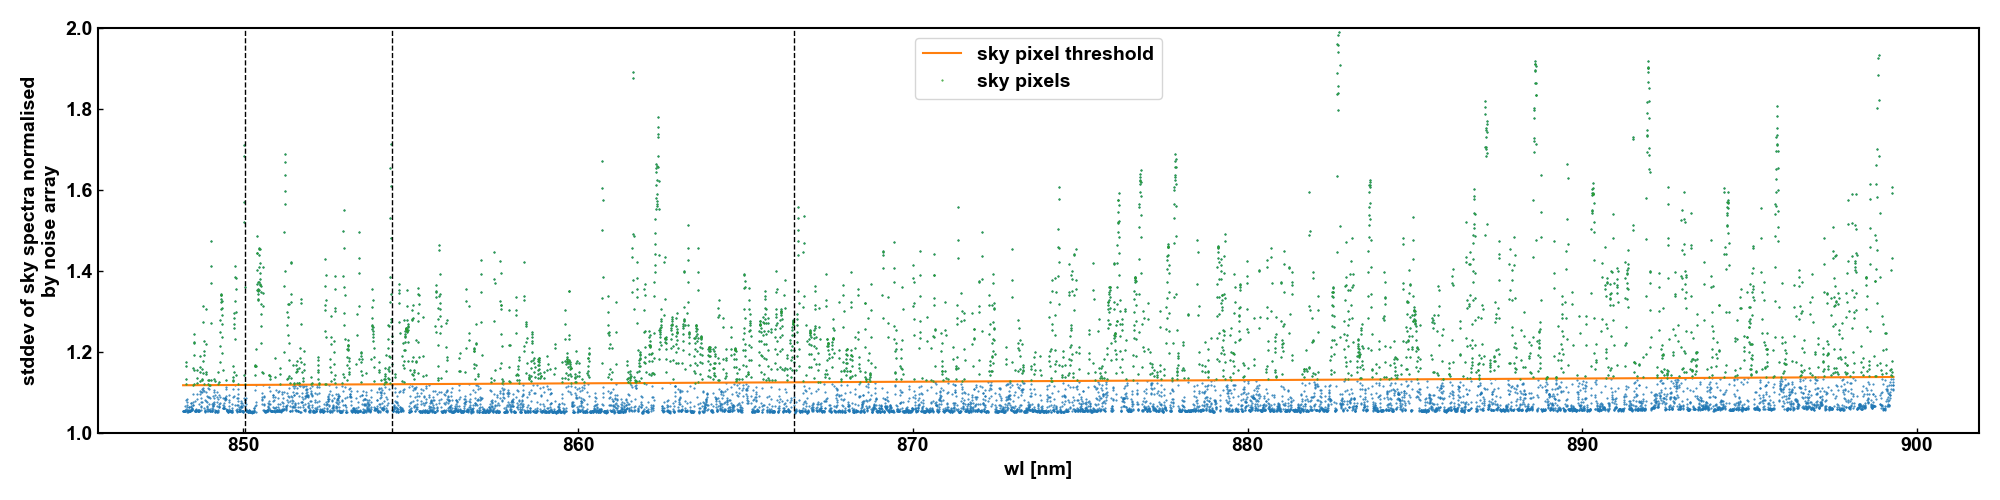

In [124]:
# calculate stddev of sky spectra normalised by noise array	
# stddev = np.sqrt(np.nanmean(flux_array**2,axis=0))
stddev = np.std(flux_array,axis=0)+np.mean(flux_array,axis=0)

# we define the sky pixels as the pixes above
# the threshold given by sky_pixles
stddev_continuum = Huber_continuum(wl,stddev)

# sky_pixel_scale_factor = 1.1 #this value was chosen by eye <<< new test
sky_pixel_scale_factor = 1.05 #this value was chosen by eye
sky_pixels = stddev>=stddev_continuum*sky_pixel_scale_factor

f, ax = plt.subplots(figsize=(20,5))  
ax.plot(wl,stddev,'.',ms=1)
ax.plot(wl,stddev_continuum*sky_pixel_scale_factor,label='sky pixel threshold')
ax.plot(wl[sky_pixels],stddev[sky_pixels],'.',ms=1,label='sky pixels')
ax.set_xlabel('wl [nm]')
ax.set_ylabel('stddev of sky spectra normalised\nby noise array')
# plt.semilogy()
ax.set_ylim(1,2)
plt.legend()
for _ in [850.04,854.44, 866.45]:
    ax.axvline(_,lw=1,ls='--',color='k')
plt.tight_layout()

PCA(n_components=22)

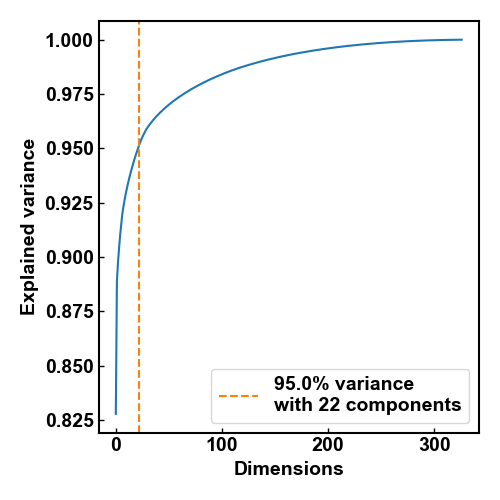

In [125]:
# 1st pca run 
pca = PCA()
pca.fit(flux_array[:,sky_pixels])
cumsum = np.cumsum(pca.explained_variance_ratio_)
# explained_variance = 0.99
explained_variance = 0.95 # new test
d = np.argmax(cumsum>=explained_variance)+1

f, ax = plt.subplots(figsize=(5,5))  
ax.plot(cumsum)
ax.axvline(d,ls='--',color='tab:orange',label='{:}% variance\nwith {:} components'.format(explained_variance*100,d))
ax.set_xlabel('Dimensions')
ax.set_ylabel('Explained variance')
plt.legend()
plt.tight_layout()

#re train
pca = PCA(n_components=d)
pca.fit(flux_array[:,sky_pixels])

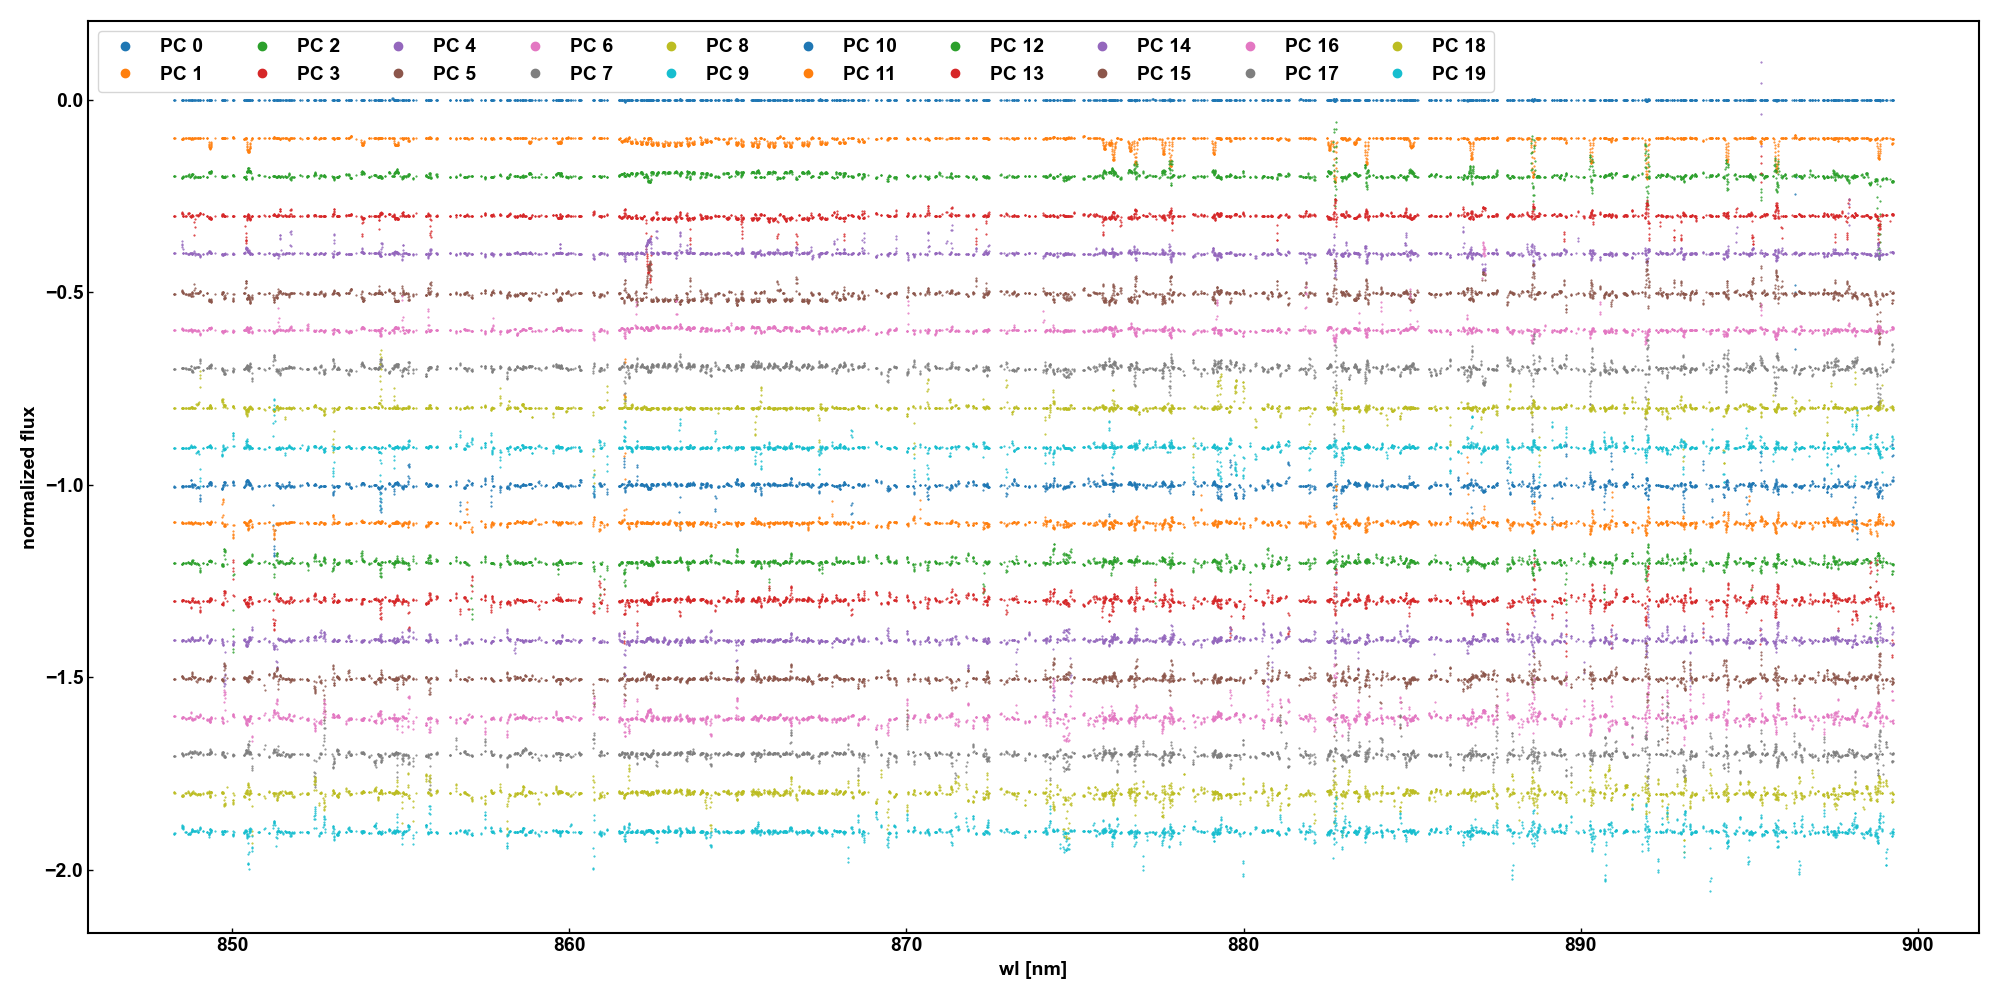

In [126]:
#plot first d-components
f, ax = plt.subplots(figsize=(20,10))

# for _ in range(d):
for _ in range(20):
    ax.plot(wl[sky_pixels],pca.components_[_]-(_*0.1),'.',ms=1,label='PC {:}'.format(_))
    ax.set_xlabel('wl [nm]')
    ax.set_ylabel('normalized flux')
    # plt.semilogy()
# plt.legend(markerscale=12,ncol=int(np.ceil(d/2)))
plt.legend(markerscale=12,ncol=int(np.ceil(20/2)))
plt.tight_layout()

In [127]:
# spec_path = '/Users/cabrera-ziri/Work/data/eso/reticulum/Results/Results/Config1/Epoch01/690286592_c1_e01_hor5_nosky.fits'
# spec_path = '/Users/cabrera-ziri/Work/data/eso/reticulum/OneDrive_1_17-01-2024/Config1/Epoch01/690286592_c1_e01_hor5.fits'
# spec_path = '/Users/cabrera-ziri/Work/data/eso/reticulum/OneDrive_1_17-01-2024/Config2/Epoch02/690006912_c2_e02_hor5.fits' #very high snr
# spec_path = '/Users/cabrera-ziri/Work/data/eso/reticulum/OneDrive_1_17-01-2024/Config1/Epoch06/690016128_c1_e06_hor5.fits'
spec_path = '/Users/cabrera-ziri/Work/data/eso/reticulum/OneDrive_1_17-01-2024/Config1/Epoch06/690050944_c1_e06_hor5.fits'

hdu = fits.open(spec_path)

ext=0 
crval = hdu[ext].header['crval1']
cdelt = hdu[ext].header['cdelt1']
naxis = hdu[ext].header['naxis1']

wl = crval+cdelt*np.arange(naxis)
flux = hdu[ext].data

# flux = flux/Huber_continuum(wl,flux)
flux = flux/poly_continuum(wl,flux)

plt.close('all')

In [128]:
weights = pca.transform(flux[sky_pixels][None,...])
model = pca.inverse_transform(weights)

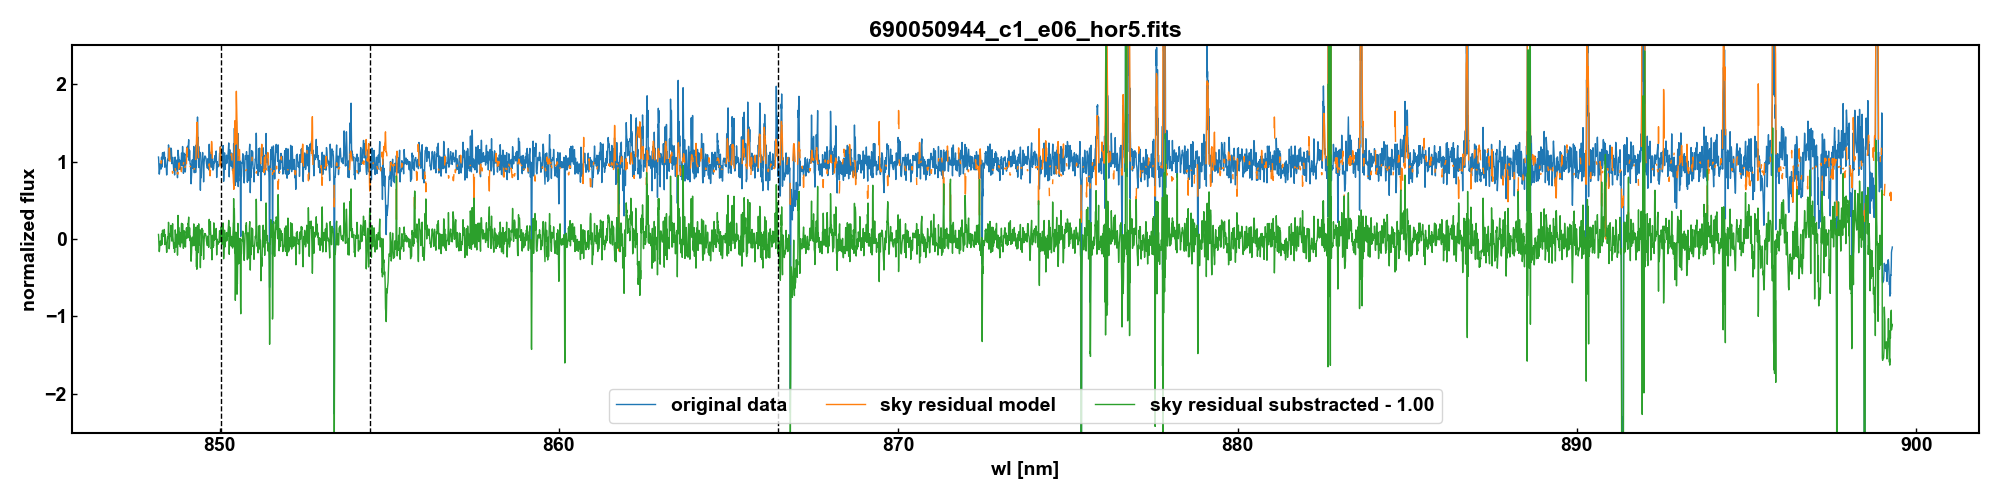

In [129]:
# centre the figure on the CaT
xlim_lo,xlim_hi = 849.1,870
ncol=3
offset = 1

plt.close('all')

f, ax = plt.subplots(figsize=(20,5))
plt.title(spec_path.split('/')[-1])
ax.plot(wl,flux,'-',lw=1,label='original data')
_model = np.ones_like(wl)*np.nan
_model[sky_pixels] = model[0,:]
ax.plot(wl,_model,'-',lw=1,label='sky residual model')
flux2 = flux.copy()
flux2[sky_pixels] = flux2[sky_pixels]-model[0,:]+1
ax.plot(wl,flux2-offset,ls='-',lw=1,label='sky residual substracted - {:.2f}'.format(offset))
for _ in [850.04,854.44, 866.45]:
    ax.axvline(_,lw=1,ls='--',color='k')
plt.legend(markerscale=12)
# ax.set_xlim(849,870)

#set automatic yscale
_flxs = np.r_[flux[(wl>=xlim_lo)&(wl<=xlim_hi)],
            flux2[(wl>=xlim_lo)&(wl<=xlim_hi)]-1,
            model[0][(wl[sky_pixels]>=xlim_lo)&(wl[sky_pixels]<=xlim_hi)]]

_flxs_min,_flxs_max = _flxs.min(),_flxs.max()

if _flxs_min<0:
    ax.set_ylim(1.1*_flxs_min,1.1*_flxs_max)
else:
    ax.set_ylim(0.9*_flxs_min,1.1*_flxs_max)

plt.legend(markerscale=12,ncol=ncol)
# ax.set_xlim(xlim_lo,xlim_hi)
ax.set_ylim(-offset*2.5,2.5*offset)
ax.set_xlabel('wl [nm]')
ax.set_ylabel('normalized flux')
plt.tight_layout()

In [59]:
# save pca models for later use
# dump([sky_pixels,pca], 'sky_residual_pca_16-01-24.joblib')
dump([sky_pixels,pca], 'sky_residual_pca_18-01-24v2.joblib')

['sky_residual_pca_18-01-24v2.joblib']